## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
# from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
import xgboost
from xgboost import XGBRegressor

## Reading Data

In [3]:
data = pd.read_csv('Electricity_Consumption_and_Cost.csv')
data.head()

/var/folders/_f/48yn95r51nn4d4jl8865yj6w0000gn/T/ipykernel_62156/1698713159.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Electricity_Consumption_and_Cost.csv')


,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,...,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,15396.82,GOV/NYC/068,Yes,128800.0,7387.97,216.0,2808.0,5200.85
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14556.34,GOV/NYC/068,Yes,115200.0,6607.87,224.0,2912.0,5036.47
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13904.98,GOV/NYC/068,Yes,103200.0,5919.55,216.0,2808.0,5177.43
3,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14764.04,GOV/NYC/068,Yes,105600.0,6057.22,208.0,2704.0,6002.82
4,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13729.54,GOV/NYC/068,Yes,97600.0,5598.34,216.0,2808.0,5323.20


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447849 entries, 0 to 447848
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Development Name    446368 non-null  object 
 1   Borough             447849 non-null  object 
 2   Account Name        447849 non-null  object 
 3   Location            436128 non-null  object 
 4   Meter AMR           447622 non-null  object 
 5   Meter Scope         23867 non-null   object 
 6   TDS #               445111 non-null  float64
 7   EDP                 447849 non-null  int64  
 8   RC Code             447849 non-null  object 
 9   Funding Source      447849 non-null  object 
 10  AMP #               445962 non-null  object 
 11  Vendor Name         447849 non-null  object 
 12  UMIS BILL ID        447849 non-null  int64  
 13  Revenue Month       447849 non-null  object 
 14  Service Start Date  447841 non-null  object 
 15  Service End Date    447841 non-nul

In [5]:
data.shape

(447849, 27)

/var/folders/_f/48yn95r51nn4d4jl8865yj6w0000gn/T/ipykernel_62156/2578434383.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),annot=True)


<Axes: >

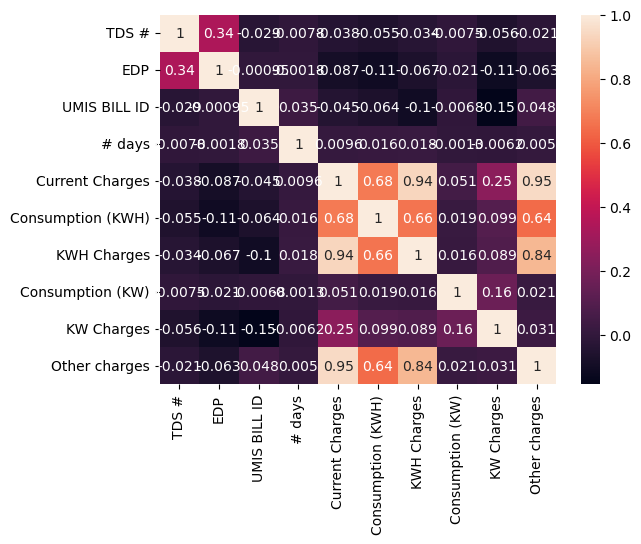

In [6]:
sns.heatmap(data.corr(),annot=True)

In [7]:
df = data[['Service Start Date','# days','Service End Date','Consumption (KWH)']]

## Taking the necessary columns to create the daily dataset

In [8]:
df

,Service Start Date,# days,Service End Date,Consumption (KWH)
0,12/24/2009,33.0,01/26/2010,128800.0
1,01/26/2010,30.0,02/25/2010,115200.0
2,02/25/2010,29.0,03/26/2010,103200.0
3,03/26/2010,31.0,04/26/2010,105600.0
4,04/26/2010,28.0,05/24/2010,97600.0
...,...,...,...,...
447844,12/23/2022,33.0,01/25/2023,0.0
447845,12/23/2022,33.0,01/25/2023,0.0
447846,12/23/2022,33.0,01/25/2023,82800.0
447847,12/23/2022,33.0,01/25/2023,90400.0


In [9]:
df.isnull().sum()

Service Start Date    8
# days                8
Service End Date      8
Consumption (KWH)     0
dtype: int64

In [10]:
df.dropna(inplace=True)

/var/folders/_f/48yn95r51nn4d4jl8865yj6w0000gn/T/ipykernel_62156/1379821321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [11]:
df.isnull().sum()

Service Start Date    0
# days                0
Service End Date      0
Consumption (KWH)     0
dtype: int64

In [12]:
df.shape

(447841, 4)

## Converting the date fields from object to datetime dtype

In [13]:
df['Service Start Date'] = pd.to_datetime(df['Service Start Date']) 
df['Service End Date'] = pd.to_datetime(df['Service End Date']) 

/var/folders/_f/48yn95r51nn4d4jl8865yj6w0000gn/T/ipykernel_62156/1144018986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Service Start Date'] = pd.to_datetime(df['Service Start Date'])
/var/folders/_f/48yn95r51nn4d4jl8865yj6w0000gn/T/ipykernel_62156/1144018986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Service End Date'] = pd.to_datetime(df['Service End Date'])


In [14]:
df.dtypes

Service Start Date    datetime64[ns]
# days                       float64
Service End Date      datetime64[ns]
Consumption (KWH)            float64
dtype: object

## Finding outliers in # days and deleting those records from the Data

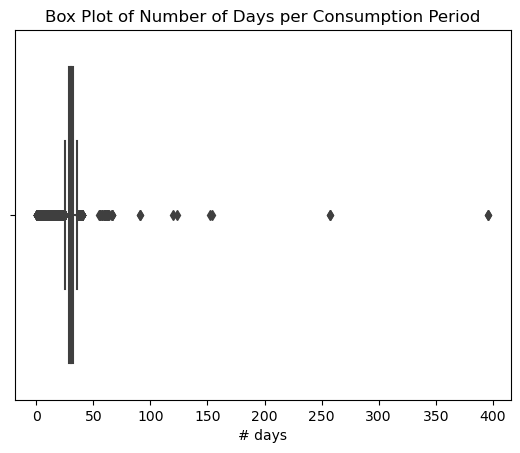

In [15]:
sns.boxplot(x=data['# days'])
plt.title('Box Plot of Number of Days per Consumption Period')
plt.show()

In [16]:
# Identify the rows where '# days' is less than 28 or greater than 33
outlier_rows = df[(df['# days'] < 28) | (df['# days'] > 33)].index

# Drop these rows from the DataFrame
data_cleaned = df.drop(outlier_rows)

In [17]:
# Calculate daily consumption
data_cleaned['Daily Consumption'] = data_cleaned['Consumption (KWH)'] / data_cleaned['# days']

# Create a daily date range for each record
data_cleaned['Date Range'] = data_cleaned.apply(lambda row: pd.date_range(row['Service Start Date'], row['Service End Date']), axis=1)

# Explode the DataFrame to have a row for each day
daily_data = data_cleaned.explode('Date Range')

# Rename and select relevant columns
daily_data = daily_data.rename(columns={'Date Range': 'Each Date'})[['Each Date', 'Daily Consumption']]

# Display the new DataFrame
print(daily_data)

        Each Date  Daily Consumption
0      2009-12-24        3903.030303
0      2009-12-25        3903.030303
0      2009-12-26        3903.030303
0      2009-12-27        3903.030303
0      2009-12-28        3903.030303
...           ...                ...
447848 2023-01-21        2981.818182
447848 2023-01-22        2981.818182
447848 2023-01-23        2981.818182
447848 2023-01-24        2981.818182
447848 2023-01-25        2981.818182

[13813487 rows x 2 columns]


In [19]:
daily_data['Each Date'].max()

Timestamp('2023-01-30 00:00:00')

In [18]:
daily_data['Each Date'].value_counts()

2020-03-25    13512
2020-02-25    13470
2020-01-24    13443
2021-02-25    10180
2021-12-23    10170
              ...  
2018-01-03        1
2018-01-02        1
2018-01-01        1
2017-12-31        1
2018-01-07        1
Name: Each Date, Length: 4095, dtype: int64

## Creating the daily dataset

In [85]:
daily_data_sum = daily_data.groupby('Each Date')['Daily Consumption'].sum()

In [86]:
daily_data_sum = pd.DataFrame(daily_data_sum)

In [87]:
daily_data_sum

,Daily Consumption
Each Date,
2009-12-24,3.146217e+06
2009-12-25,3.146217e+06
2009-12-26,3.146217e+06
2009-12-27,3.146217e+06
2009-12-28,3.146217e+06
...,...
2023-01-26,2.491283e+04
2023-01-27,4.507500e+03
2023-01-28,4.507500e+03


<Axes: xlabel='Each Date'>

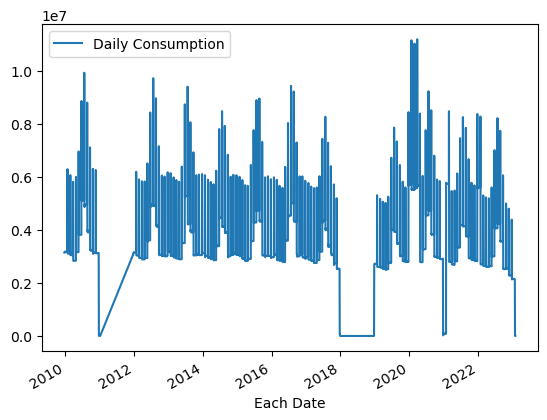

In [88]:
daily_data_sum.plot()

In [89]:
daily_data_sum.reset_index(inplace=True)

In [90]:

daily_data_sum = daily_data_sum.rename(columns={'Each Date':'Service Start Date','Daily Consumption':'Consumption (KWH)'})

## Creating daily dataset with Numeric Features

In [91]:
# df.rename(columns={'Service Start Date': 'ds', 'Consumption (KWH)': 'y'})
DF = daily_data_sum.rename(columns={'Each Date':'Service Start Date','Daily Consumption':'Consumption (KWH)'})

In [92]:
DF

,Service Start Date,Consumption (KWH)
0,2009-12-24,3.146217e+06
1,2009-12-25,3.146217e+06
2,2009-12-26,3.146217e+06
3,2009-12-27,3.146217e+06
4,2009-12-28,3.146217e+06
...,...,...
4090,2023-01-26,2.491283e+04
4091,2023-01-27,4.507500e+03
4092,2023-01-28,4.507500e+03
4093,2023-01-29,4.507500e+03


## Creating daily dataset for adding External Factor(Temperature)

In [93]:
DF_temp = daily_data_sum.rename(columns={'Each Date':'Service Start Date','Daily Consumption':'Consumption (KWH)'})

In [94]:
DF_temp

,Service Start Date,Consumption (KWH)
0,2009-12-24,3.146217e+06
1,2009-12-25,3.146217e+06
2,2009-12-26,3.146217e+06
3,2009-12-27,3.146217e+06
4,2009-12-28,3.146217e+06
...,...,...
4090,2023-01-26,2.491283e+04
4091,2023-01-27,4.507500e+03
4092,2023-01-28,4.507500e+03
4093,2023-01-29,4.507500e+03


In [95]:
daily_data_sum.set_index('Service Start Date',inplace=True)

## Creating Monthly Dataset

In [31]:
# Group by month and calculate the sum
monthly_data = daily_data_sum.resample('M').sum()

In [32]:
# Format the index to keep only the year and month
monthly_data.index = monthly_data.index.strftime('%Y-%m')

<Axes: xlabel='Service Start Date'>

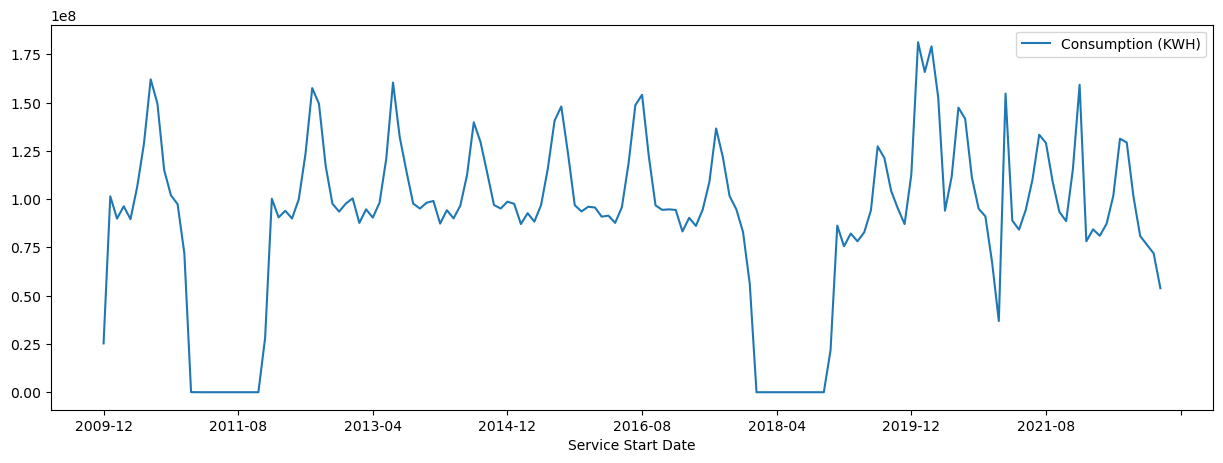

In [33]:
monthly_data.plot(figsize=(15,5))

In [34]:
monthly_data

,Consumption (KWH)
Service Start Date,
2009-12,2.528582e+07
2010-01,1.014641e+08
2010-02,8.991616e+07
2010-03,9.630300e+07
2010-04,8.962818e+07
...,...
2022-09,1.013543e+08
2022-10,8.089626e+07
2022-11,7.643075e+07


## Creating the Yearly Dataset

In [35]:
# Group by year and calculate the sum
yearly_data = daily_data_sum.resample('A').sum()

In [36]:
# Format the index to keep only the year
yearly_data.index = yearly_data.index.strftime('%Y')

# Now the index of 'yearly_data' will have the format 'YYYY'

In [37]:
yearly_data

,Consumption (KWH)
Service Start Date,
2009,2.528582e+07
2010,1.310643e+09
2011,2.815219e+07
2012,1.311111e+09
2013,1.290197e+09
2014,1.253506e+09
2015,1.277355e+09
2016,1.291163e+09
2017,1.151283e+09


<Axes: xlabel='Service Start Date'>

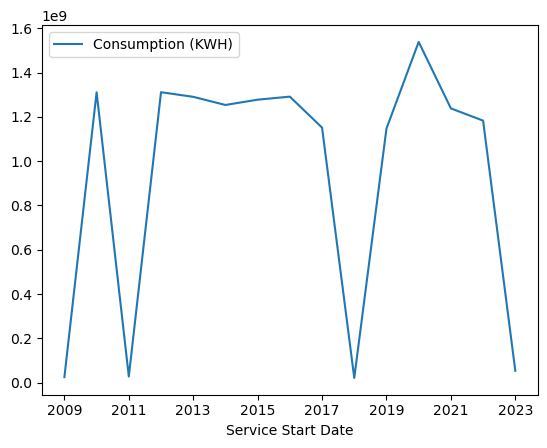

In [38]:
yearly_data.plot()

## Training and Evaluating xgboostregressor model with the original dataframe containing daily energy consumption

In [39]:
daily_data_sum

,Consumption (KWH)
Service Start Date,
2009-12-24,3.146217e+06
2009-12-25,3.146217e+06
2009-12-26,3.146217e+06
2009-12-27,3.146217e+06
2009-12-28,3.146217e+06
...,...
2023-01-26,2.491283e+04
2023-01-27,4.507500e+03
2023-01-28,4.507500e+03


## Adding lag Feature to see how a previous Consumption value affects the next day's Consumption, as having nothing to correlate leads in a straight line with no change.

In [154]:
daily_data_sum['Consumption_Lag1'] = daily_data_sum['Consumption (KWH)'].shift(1)

In [155]:
daily_data_sum

,Consumption (KWH),Consumption_Lag1
Service Start Date,,
2009-12-24,3.146217e+06,NaN
2009-12-25,3.146217e+06,3.146217e+06
2009-12-26,3.146217e+06,3.146217e+06
2009-12-27,3.146217e+06,3.146217e+06
2009-12-28,3.146217e+06,3.146217e+06
...,...,...
2023-01-26,2.491283e+04,2.140346e+06
2023-01-27,4.507500e+03,2.491283e+04
2023-01-28,4.507500e+03,4.507500e+03


## Dropping the first row if it still contains NaN after filling

In [156]:
daily_data_sum.dropna(inplace=True)

## Dropping the Service Start Date Column as xgboost models dont support data types other than bool, int, float , category

In [157]:
daily_data_sum.reset_index(inplace=True)

In [158]:
daily_data_sum.drop('Service Start Date',inplace=True,axis=1)

In [218]:
daily_data_sum

,index,Consumption (KWH),Consumption_Lag1
0,0,3.146217e+06,3.146217e+06
1,1,3.146217e+06,3.146217e+06
2,2,3.146217e+06,3.146217e+06
3,3,3.146217e+06,3.146217e+06
4,4,3.184909e+06,3.146217e+06
...,...,...,...
4089,4089,2.491283e+04,2.140346e+06
4090,4090,4.507500e+03,2.491283e+04
4091,4091,4.507500e+03,4.507500e+03
4092,4092,4.507500e+03,4.507500e+03


## Adding the Index Column as we need something in the dataset to plot against the target value

In [160]:
daily_data_sum.reset_index(inplace=True)

In [219]:
# Define your train and test sets
train = daily_data_sum[:-3065]
test = daily_data_sum[-3065:]

X_train = train.drop('Consumption (KWH)', axis=1)
y_train = train['Consumption (KWH)']
X_test = test.drop('Consumption (KWH)', axis=1)
y_test = test['Consumption (KWH)']


Setting the objective to reg:squarederror in XGBoost for time series forecasting is appropriate when you are dealing with a regression problem, which is often the case in time series forecasting. In this time series forecasting, the goal is typically to predict a continuous future value based on past observations, making it a regression task. 

Mean absolute Error: 193843.49113526812
Mean absolute percentage Error: 4.813430026916768%
Mean absolute Error: 504903.7892863162
Mean absolute percentage Error: 15.567917900457628%
Mean absolute Error: 792485.1185992766
Mean absolute percentage Error: 22.02575396158281%


/var/folders/_f/48yn95r51nn4d4jl8865yj6w0000gn/T/ipykernel_62156/1895262234.py:27: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()  # Adjust the layout
/Users/swethavoora/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


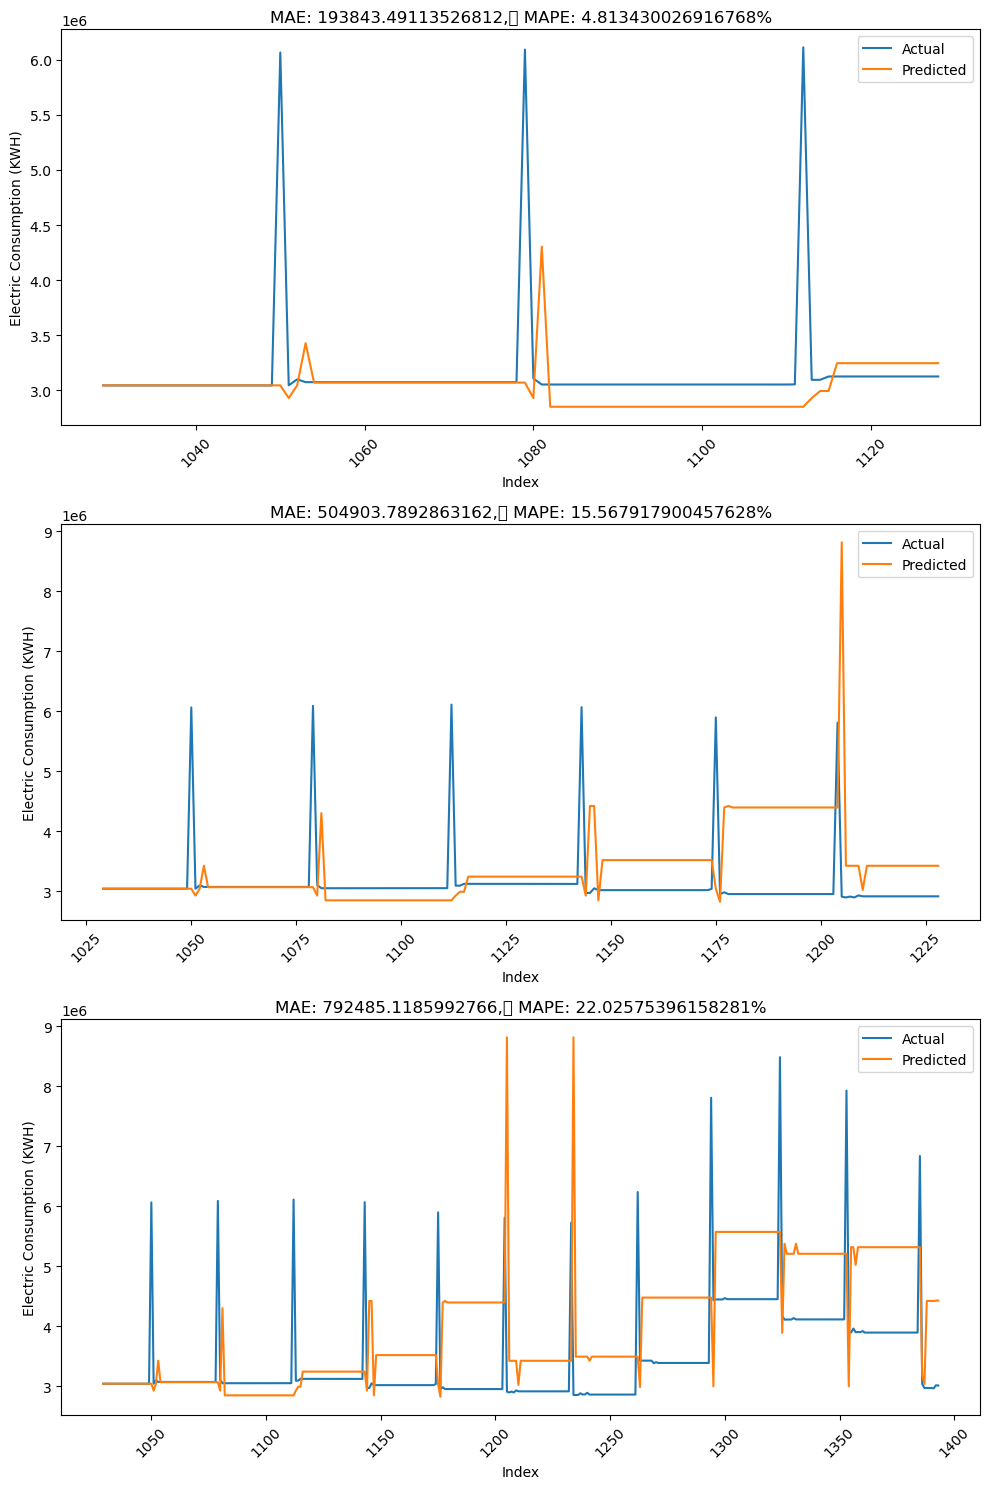

In [220]:

# from xgboost import XGBRegressor

periods = [100, 200, 365]
fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # Adjust figure size as needed

for i, period in enumerate(periods):
    model = XGBRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test[:period], predictions[:period])
    mape = np.mean(np.abs((y_test[:period] - predictions[:period]) / y_test)) * 100
    print(f"Mean absolute Error: {mae}")
    print(f"Mean absolute percentage Error: {mape}%")
    # Plotting the actual and predicted values
    axes[i].plot(X_test['index'][:period], y_test[:period], label='Actual')
    axes[i].plot(X_test['index'][:period], predictions[:period], label='Predicted')

    # Set titles and labels
    axes[i].set_title(f"MAE: {mae},\t MAPE: {mape}%")
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Electric Consumption (KWH)')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axes[i].legend()

mae1 = mae
mape1 = mape
plt.tight_layout()  # Adjust the layout
plt.show()

## Creating Lag for Monthly Dataset

In [49]:
monthly_data['Consumption_Lag1'] = monthly_data['Consumption (KWH)'].shift(1)

In [50]:
monthly_data

,Consumption (KWH),Consumption_Lag1
Service Start Date,,
2009-12,2.528582e+07,NaN
2010-01,1.014641e+08,2.528582e+07
2010-02,8.991616e+07,1.014641e+08
2010-03,9.630300e+07,8.991616e+07
2010-04,8.962818e+07,9.630300e+07
...,...,...
2022-09,1.013543e+08,1.293409e+08
2022-10,8.089626e+07,1.013543e+08
2022-11,7.643075e+07,8.089626e+07


In [51]:
# Dropping the first row if it still contains NaN after filling
monthly_data.dropna(inplace=True)

In [52]:
monthly_data

,Consumption (KWH),Consumption_Lag1
Service Start Date,,
2010-01,1.014641e+08,2.528582e+07
2010-02,8.991616e+07,1.014641e+08
2010-03,9.630300e+07,8.991616e+07
2010-04,8.962818e+07,9.630300e+07
2010-05,1.064781e+08,8.962818e+07
...,...,...
2022-09,1.013543e+08,1.293409e+08
2022-10,8.089626e+07,1.013543e+08
2022-11,7.643075e+07,8.089626e+07


In [53]:
monthly_data_original = monthly_data.reset_index()

In [54]:
monthly_data_original.drop('Service Start Date',inplace=True, axis=1)

In [55]:
monthly_data_original.reset_index(inplace=True)

In [56]:
monthly_data_original

,index,Consumption (KWH),Consumption_Lag1
0,0,1.014641e+08,2.528582e+07
1,1,8.991616e+07,1.014641e+08
2,2,9.630300e+07,8.991616e+07
3,3,8.962818e+07,9.630300e+07
4,4,1.064781e+08,8.962818e+07
...,...,...,...
152,152,1.013543e+08,1.293409e+08
153,153,8.089626e+07,1.013543e+08
154,154,7.643075e+07,8.089626e+07
155,155,7.189916e+07,7.643075e+07


In [221]:
# Define your train and test sets
# For example, let's use the last 30 days as test data
train = monthly_data_original[:-15]
test = monthly_data_original[-15:]

X_train = train.drop('Consumption (KWH)', axis=1)
y_train = train['Consumption (KWH)']
X_test = test.drop('Consumption (KWH)', axis=1)
y_test = test['Consumption (KWH)']


Mean absolute Error: 28569103.163805585
Mean absolute percentage Error: 20.07623621849107%
Mean absolute Error: 20329279.356559817
Mean absolute percentage Error: 17.6828310845766%
Mean absolute Error: 19144261.38107268
Mean absolute percentage Error: 16.384099145679432%


/var/folders/_f/48yn95r51nn4d4jl8865yj6w0000gn/T/ipykernel_62156/2988596758.py:24: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()  # Adjust the layout
/Users/swethavoora/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


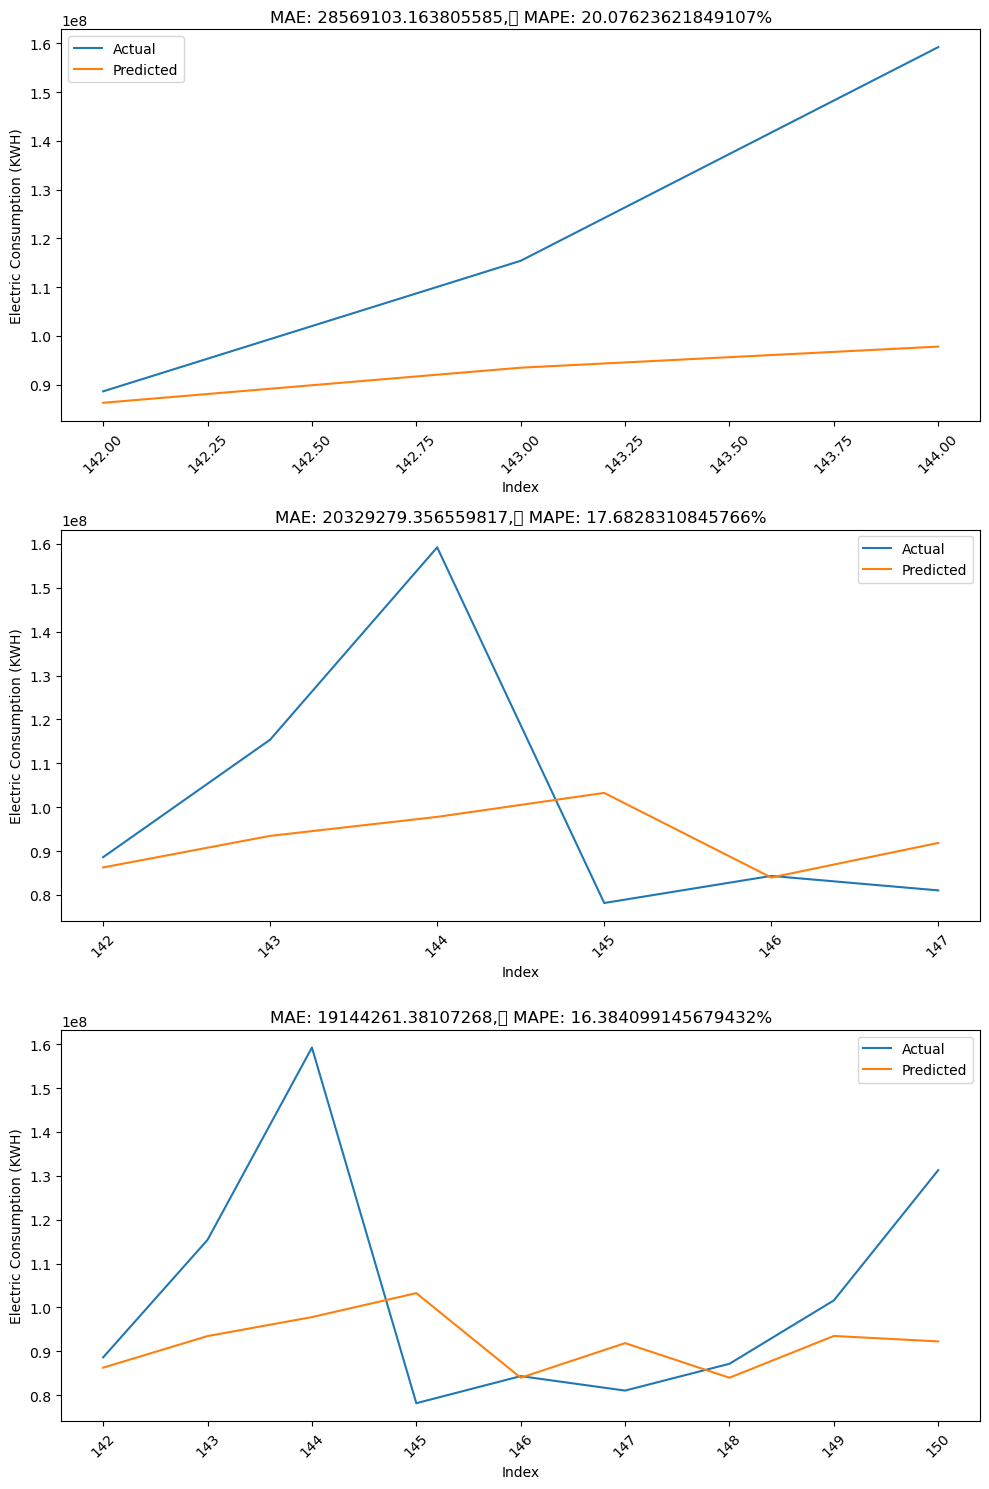

In [222]:

periods = [3, 6, 9]
fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # Adjust figure size as needed

for i, period in enumerate(periods):
    model = XGBRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test[:period], predictions[:period])
    mape = np.mean(np.abs((y_test[:period] - predictions[:period]) / y_test)) * 100
    print(f"Mean absolute Error: {mae}")
    print(f"Mean absolute percentage Error: {mape}%")
    
    # Plotting the actual and predicted values
    axes[i].plot(X_test['index'][:period], y_test[:period], label='Actual')
    axes[i].plot(X_test['index'][:period], predictions[:period], label='Predicted')

    # Set titles and labels
    axes[i].set_title(f"MAE: {mae},\t MAPE: {mape}%")
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Electric Consumption (KWH)')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axes[i].legend()
    
plt.tight_layout()  # Adjust the layout
plt.show()

## Creating lag for yearly dataset

In [59]:
yearly_data['Consumption_Lag1'] = yearly_data['Consumption (KWH)'].shift(1)

In [60]:

# Dropping the first row if it still contains NaN after filling
yearly_data.dropna(inplace=True)

In [223]:
yearly_data

,Consumption (KWH),Consumption_Lag1
Service Start Date,,
2010,1.310643e+09,2.528582e+07
2011,2.815219e+07,1.310643e+09
2012,1.311111e+09,2.815219e+07
2013,1.290197e+09,1.311111e+09
2014,1.253506e+09,1.290197e+09
2015,1.277355e+09,1.253506e+09
2016,1.291163e+09,1.277355e+09
2017,1.151283e+09,1.291163e+09
2018,2.173791e+07,1.151283e+09


In [62]:
yearly_data_original = yearly_data.reset_index()

In [63]:
yearly_data_original

,Service Start Date,Consumption (KWH),Consumption_Lag1
0,2010,1.310643e+09,2.528582e+07
1,2011,2.815219e+07,1.310643e+09
2,2012,1.311111e+09,2.815219e+07
3,2013,1.290197e+09,1.311111e+09
4,2014,1.253506e+09,1.290197e+09
5,2015,1.277355e+09,1.253506e+09
6,2016,1.291163e+09,1.277355e+09
7,2017,1.151283e+09,1.291163e+09
8,2018,2.173791e+07,1.151283e+09
9,2019,1.147120e+09,2.173791e+07


In [64]:
yearly_data_original.drop('Service Start Date',inplace=True, axis=1)

In [65]:
yearly_data_original.reset_index(inplace=True)

In [66]:
yearly_data_original

,index,Consumption (KWH),Consumption_Lag1
0,0,1.310643e+09,2.528582e+07
1,1,2.815219e+07,1.310643e+09
2,2,1.311111e+09,2.815219e+07
3,3,1.290197e+09,1.311111e+09
4,4,1.253506e+09,1.290197e+09
5,5,1.277355e+09,1.253506e+09
6,6,1.291163e+09,1.277355e+09
7,7,1.151283e+09,1.291163e+09
8,8,2.173791e+07,1.151283e+09
9,9,1.147120e+09,2.173791e+07


In [224]:
# Define your train and test sets
# For example, let's use the last 30 days as test data
train = yearly_data_original[:-5]
test = yearly_data_original[-5:]

X_train = train.drop('Consumption (KWH)', axis=1)
y_train = train['Consumption (KWH)']
X_test = test.drop('Consumption (KWH)', axis=1)
y_test = test['Consumption (KWH)']


Mean absolute Error: 1320835442.4757414
Mean absolute percentage Error: 98.34580185972325%
Mean absolute Error: 1010235305.8525226
Mean absolute percentage Error: 90.54808095293895%
Mean absolute Error: 1010235305.8525226
Mean absolute percentage Error: 90.54808095293895%


/var/folders/_f/48yn95r51nn4d4jl8865yj6w0000gn/T/ipykernel_62156/2871561703.py:23: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()  # Adjust the layout
/Users/swethavoora/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


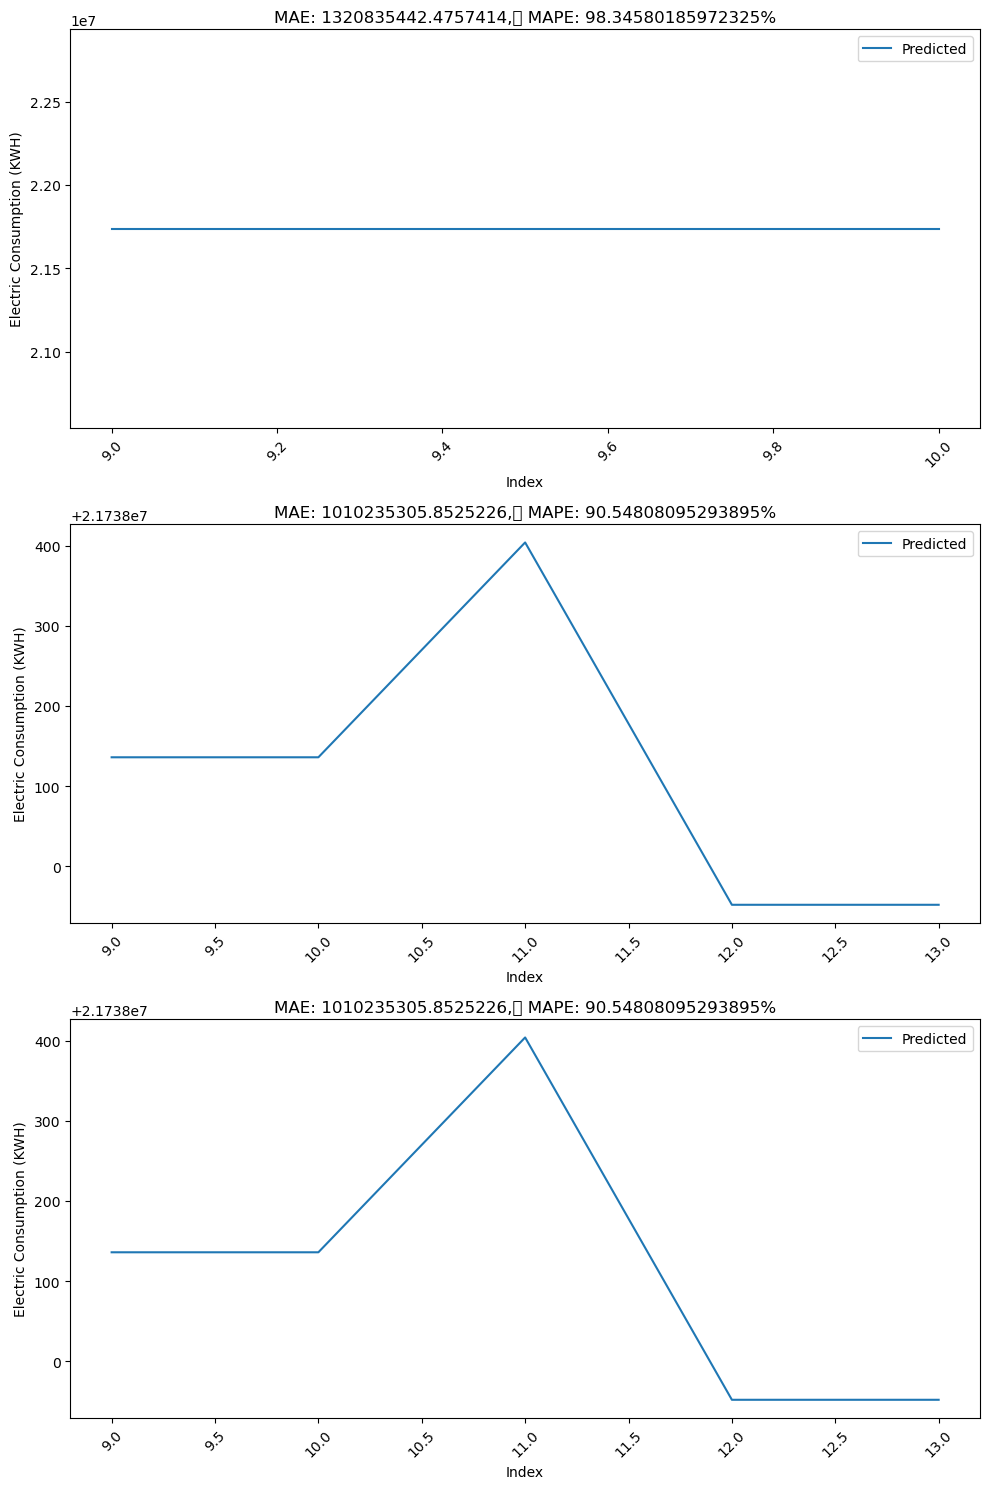

In [225]:
periods = [2, 10, 20]
fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # Adjust figure size as needed

for i, period in enumerate(periods):
    model = XGBRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test[:period], predictions[:period])
    mape = np.mean(np.abs((y_test[:period] - predictions[:period]) / y_test)) * 100
    print(f"Mean absolute Error: {mae}")
    print(f"Mean absolute percentage Error: {mape}%")
    # Plotting the actual and predicted values
#     axes[i].plot(X_test['index'][:period], y_test[:period], label='Actual')
    axes[i].plot(X_test['index'][:period], predictions[:period], label='Predicted')

    # Set titles and labels
    axes[i].set_title(f"MAE: {mae},\t MAPE: {mape}%")
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Electric Consumption (KWH)')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axes[i].legend()
    
plt.tight_layout()  # Adjust the layout
plt.show()


## Training and Evaluating xgbregressor using numeric features extracted using Service Date column

In [96]:
DF

,Service Start Date,Consumption (KWH)
0,2009-12-24,3.146217e+06
1,2009-12-25,3.146217e+06
2,2009-12-26,3.146217e+06
3,2009-12-27,3.146217e+06
4,2009-12-28,3.146217e+06
...,...,...
4090,2023-01-26,2.491283e+04
4091,2023-01-27,4.507500e+03
4092,2023-01-28,4.507500e+03
4093,2023-01-29,4.507500e+03


## Time-Based Feature Extraction:

In [97]:
DF['Day_of_Week'] = DF['Service Start Date'].dt.dayofweek
DF['Month_of_Year'] = DF['Service Start Date'].dt.month
DF['Week_of_Year'] = DF['Service Start Date'].dt.isocalendar().week
DF['Year'] = DF['Service Start Date'].dt.year

In [98]:
DF

,Service Start Date,Consumption (KWH),Day_of_Week,Month_of_Year,Week_of_Year,Year
0,2009-12-24,3.146217e+06,3,12,52,2009
1,2009-12-25,3.146217e+06,4,12,52,2009
2,2009-12-26,3.146217e+06,5,12,52,2009
3,2009-12-27,3.146217e+06,6,12,52,2009
4,2009-12-28,3.146217e+06,0,12,53,2009
...,...,...,...,...,...,...
4090,2023-01-26,2.491283e+04,3,1,4,2023
4091,2023-01-27,4.507500e+03,4,1,4,2023
4092,2023-01-28,4.507500e+03,5,1,4,2023
4093,2023-01-29,4.507500e+03,6,1,4,2023


In [99]:
DF.reset_index(inplace=True)

In [100]:
DF

,index,Service Start Date,Consumption (KWH),Day_of_Week,Month_of_Year,Week_of_Year,Year
0,0,2009-12-24,3.146217e+06,3,12,52,2009
1,1,2009-12-25,3.146217e+06,4,12,52,2009
2,2,2009-12-26,3.146217e+06,5,12,52,2009
3,3,2009-12-27,3.146217e+06,6,12,52,2009
4,4,2009-12-28,3.146217e+06,0,12,53,2009
...,...,...,...,...,...,...,...
4090,4090,2023-01-26,2.491283e+04,3,1,4,2023
4091,4091,2023-01-27,4.507500e+03,4,1,4,2023
4092,4092,2023-01-28,4.507500e+03,5,1,4,2023
4093,4093,2023-01-29,4.507500e+03,6,1,4,2023


In [101]:

# Dropping the first row if it still contains NaN after filling
# DF.dropna(inplace=True)

In [102]:
# Drop the original date column
DF.drop(['Service Start Date'], axis=1, inplace=True)

In [103]:
# DF.drop('Consumption_Lag1',inplace=True, axis=1)

In [226]:
DF

,index,Consumption (KWH),Day_of_Week,Month_of_Year,Week_of_Year,Year
0,0,3.146217e+06,3,12,52,2009
1,1,3.146217e+06,4,12,52,2009
2,2,3.146217e+06,5,12,52,2009
3,3,3.146217e+06,6,12,52,2009
4,4,3.146217e+06,0,12,53,2009
...,...,...,...,...,...,...
4090,4090,2.491283e+04,3,1,4,2023
4091,4091,4.507500e+03,4,1,4,2023
4092,4092,4.507500e+03,5,1,4,2023
4093,4093,4.507500e+03,6,1,4,2023


In [227]:
# Define your train and test sets
# For example, let's use the last 30 days as test data
train = DF[:-3065]
test = DF[-3065:]

X_train = train.drop('Consumption (KWH)', axis=1)
y_train = train['Consumption (KWH)']
X_test = test.drop('Consumption (KWH)', axis=1)
y_test = test['Consumption (KWH)']


Mean absolute Error: 284006.07427636767
Mean absolute percentage Error: 7.800261513962909%
Mean absolute Error: 321268.6071653545
Mean absolute percentage Error: 9.13181946780896%
Mean absolute Error: 356753.7452653689
Mean absolute percentage Error: 9.169129158581434%


/var/folders/_f/48yn95r51nn4d4jl8865yj6w0000gn/T/ipykernel_62156/2907913414.py:29: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()  # Adjust the layout
/Users/swethavoora/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


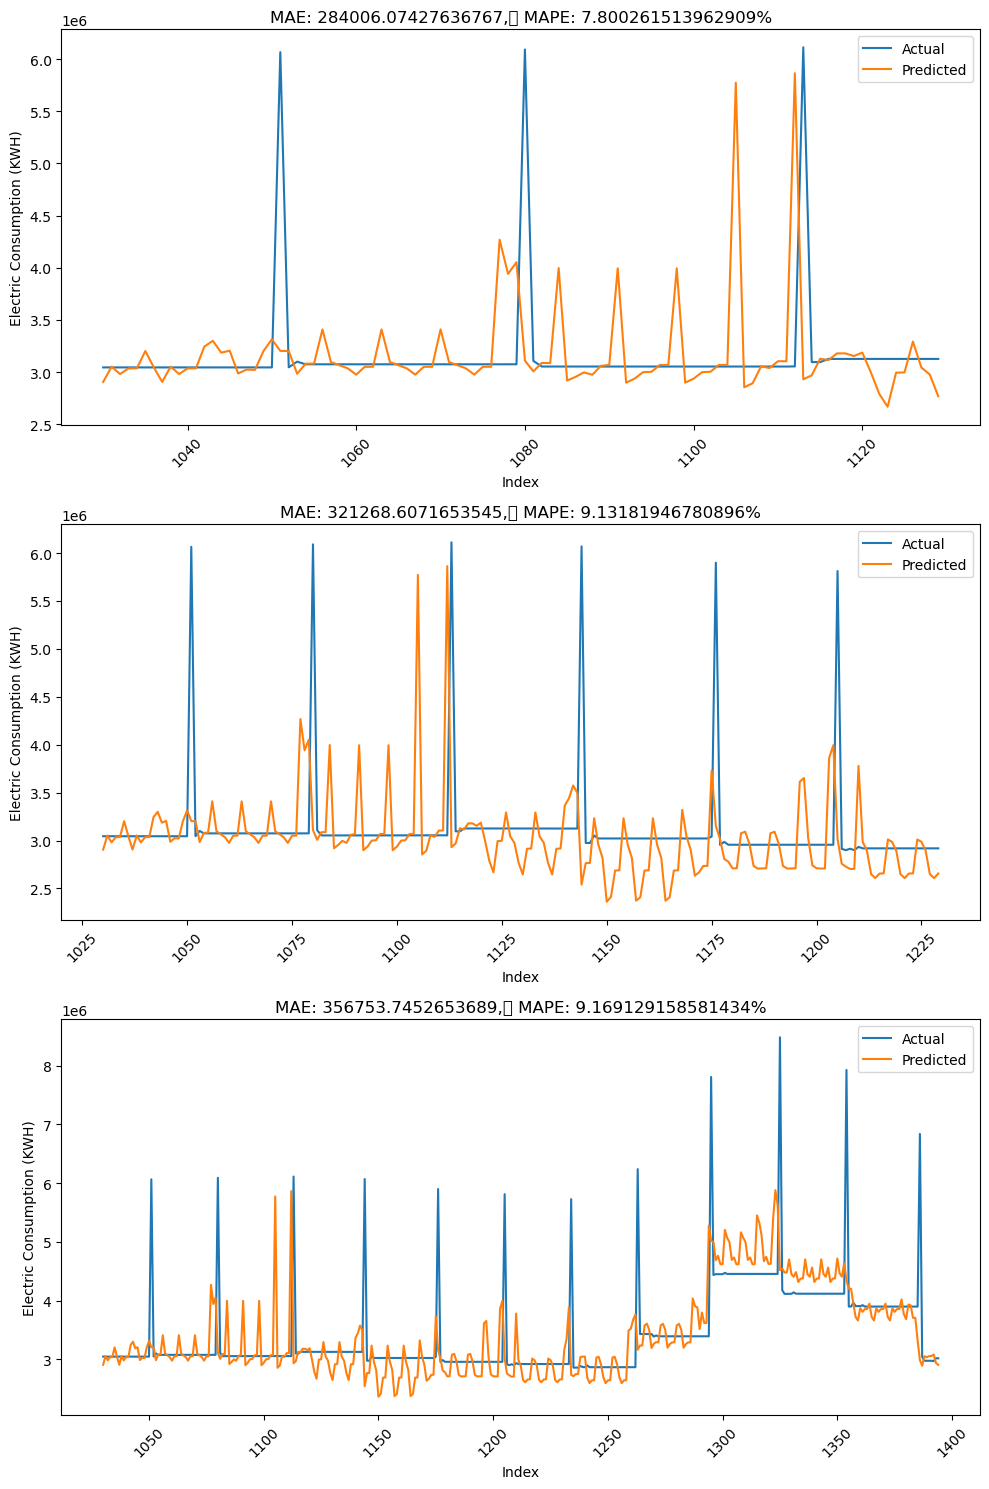

In [228]:

# from xgboost import XGBRegressor

periods = [100, 200, 365]
fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # Adjust figure size as needed

for i, period in enumerate(periods):
    model = XGBRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test[:period], predictions[:period])
    mape = np.mean(np.abs((y_test[:period] - predictions[:period]) / y_test)) * 100
    print(f"Mean absolute Error: {mae}")
    print(f"Mean absolute percentage Error: {mape}%")
    
    # Plotting the actual and predicted values
    axes[i].plot(X_test['index'][:period], y_test[:period], label='Actual')
    axes[i].plot(X_test['index'][:period], predictions[:period], label='Predicted')

    # Set titles and labels
    axes[i].set_title(f"MAE: {mae},\t MAPE: {mape}%")
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Electric Consumption (KWH)')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axes[i].legend()

mae2 = mae
mape2 = mape
    
plt.tight_layout()  # Adjust the layout
plt.show()


# from xgboost import XGBRegressor
# model = XGBRegressor(objective='reg:squarederror',
#     n_estimators=350,
#     max_depth=11,  # Example, needs tuning
#     learning_rate=0.9,  # Example, needs tuning
#     subsample=0.8,  # Example, needs tuning
#     colsample_bytree=0.8 )
# model.fit(X_train, y_train)

# Adding External Factors - Temperature

In [107]:
DF_temp

,Service Start Date,Consumption (KWH)
0,2009-12-24,3.146217e+06
1,2009-12-25,3.146217e+06
2,2009-12-26,3.146217e+06
3,2009-12-27,3.146217e+06
4,2009-12-28,3.146217e+06
...,...,...
4090,2023-01-26,2.491283e+04
4091,2023-01-27,4.507500e+03
4092,2023-01-28,4.507500e+03
4093,2023-01-29,4.507500e+03


In [86]:
# DF_temp.reset_index(inplace=True)

In [87]:
# DF_temp.rename(columns={'Each Date':'Service Start Date'},inplace=True)

In [108]:
# DF_temp

,Service Start Date,Consumption (KWH)
0,2009-12-24,3.146217e+06
1,2009-12-25,3.146217e+06
2,2009-12-26,3.146217e+06
3,2009-12-27,3.146217e+06
4,2009-12-28,3.146217e+06
...,...,...
4090,2023-01-26,2.491283e+04
4091,2023-01-27,4.507500e+03
4092,2023-01-28,4.507500e+03
4093,2023-01-29,4.507500e+03


In [109]:
#Time-Based Feature Extraction:
# Extracting time-based features
DF_temp['Day_of_Week'] = DF_temp['Service Start Date'].dt.dayofweek
DF_temp['Month_of_Year'] = DF_temp['Service Start Date'].dt.month
DF_temp['Week_of_Year'] = DF_temp['Service Start Date'].dt.isocalendar().week
DF_temp['Year'] = DF_temp['Service Start Date'].dt.year

In [110]:
DF_temp

,Service Start Date,Consumption (KWH),Day_of_Week,Month_of_Year,Week_of_Year,Year
0,2009-12-24,3.146217e+06,3,12,52,2009
1,2009-12-25,3.146217e+06,4,12,52,2009
2,2009-12-26,3.146217e+06,5,12,52,2009
3,2009-12-27,3.146217e+06,6,12,52,2009
4,2009-12-28,3.146217e+06,0,12,53,2009
...,...,...,...,...,...,...
4090,2023-01-26,2.491283e+04,3,1,4,2023
4091,2023-01-27,4.507500e+03,4,1,4,2023
4092,2023-01-28,4.507500e+03,5,1,4,2023
4093,2023-01-29,4.507500e+03,6,1,4,2023


In [111]:
DF_temp.set_index('Service Start Date',inplace=True)

In [112]:
DF_temp

,Consumption (KWH),Day_of_Week,Month_of_Year,Week_of_Year,Year
Service Start Date,,,,,
2009-12-24,3.146217e+06,3,12,52,2009
2009-12-25,3.146217e+06,4,12,52,2009
2009-12-26,3.146217e+06,5,12,52,2009
2009-12-27,3.146217e+06,6,12,52,2009
2009-12-28,3.146217e+06,0,12,53,2009
...,...,...,...,...,...
2023-01-26,2.491283e+04,3,1,4,2023
2023-01-27,4.507500e+03,4,1,4,2023
2023-01-28,4.507500e+03,5,1,4,2023


# Incorporating External Factors:

Data Collected using 'https://www.ncdc.noaa.gov/cdo-web/search'

In [113]:
nyc_temp = pd.read_csv('3548781.csv')
nyc_temp = nyc_temp[['DATE','TMAX']]

## Renaming the columns to match the date field in the weather data with the energy consumption data to merge easily

In [114]:
nyc_temp.rename(columns={'DATE':'Service Start Date','TMAX':'Temperature'},inplace=True)

In [115]:
nyc_temp['Service Start Date'] = pd.to_datetime(nyc_temp['Service Start Date'])

In [116]:
nyc_temp.set_index('Service Start Date',inplace=True)

In [117]:
nyc_temp

,Temperature
Service Start Date,
2009-12-24,38
2009-12-25,40
2009-12-26,52
2009-12-27,54
2009-12-28,44
...,...
2023-01-26,52
2023-01-27,43
2023-01-28,53


In [118]:
nyc_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4786 entries, 2009-12-24 to 2023-01-30
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Temperature  4786 non-null   int64
dtypes: int64(1)
memory usage: 74.8 KB


## Adding the Temperature Factor to the energy consumption dataframe

In [119]:
DF_temp = pd.merge(DF_temp, nyc_temp[['Temperature']], on='Service Start Date', how='inner')

In [120]:
DF_temp

,Consumption (KWH),Day_of_Week,Month_of_Year,Week_of_Year,Year,Temperature
Service Start Date,,,,,,
2009-12-24,3.146217e+06,3,12,52,2009,38
2009-12-25,3.146217e+06,4,12,52,2009,40
2009-12-26,3.146217e+06,5,12,52,2009,52
2009-12-27,3.146217e+06,6,12,52,2009,54
2009-12-28,3.146217e+06,0,12,53,2009,44
...,...,...,...,...,...,...
2023-01-26,2.491283e+04,3,1,4,2023,52
2023-01-27,4.507500e+03,4,1,4,2023,43
2023-01-28,4.507500e+03,5,1,4,2023,53


In [121]:
DF_temp.reset_index(inplace=True)

In [122]:
DF_temp

,Service Start Date,Consumption (KWH),Day_of_Week,Month_of_Year,Week_of_Year,Year,Temperature
0,2009-12-24,3.146217e+06,3,12,52,2009,38
1,2009-12-25,3.146217e+06,4,12,52,2009,40
2,2009-12-26,3.146217e+06,5,12,52,2009,52
3,2009-12-27,3.146217e+06,6,12,52,2009,54
4,2009-12-28,3.146217e+06,0,12,53,2009,44
...,...,...,...,...,...,...,...
4090,2023-01-26,2.491283e+04,3,1,4,2023,52
4091,2023-01-27,4.507500e+03,4,1,4,2023,43
4092,2023-01-28,4.507500e+03,5,1,4,2023,53
4093,2023-01-29,4.507500e+03,6,1,4,2023,47


In [123]:
DF_temp.drop('Service Start Date',inplace=True, axis=1)

In [124]:
DF_temp.reset_index(inplace=True)

In [229]:
DF_temp

,index,Consumption (KWH),Day_of_Week,Month_of_Year,Week_of_Year,Year,Temperature
0,0,3.146217e+06,3,12,52,2009,38
1,1,3.146217e+06,4,12,52,2009,40
2,2,3.146217e+06,5,12,52,2009,52
3,3,3.146217e+06,6,12,52,2009,54
4,4,3.146217e+06,0,12,53,2009,44
...,...,...,...,...,...,...,...
4090,4090,2.491283e+04,3,1,4,2023,52
4091,4091,4.507500e+03,4,1,4,2023,43
4092,4092,4.507500e+03,5,1,4,2023,53
4093,4093,4.507500e+03,6,1,4,2023,47


In [230]:
# Define your train and test sets
# For example, let's use the last 30 days as test data
train = DF_temp[:-3325]
test = DF_temp[-3325:]

X_train = train.drop('Consumption (KWH)', axis=1)
y_train = train['Consumption (KWH)']
X_test = test.drop('Consumption (KWH)', axis=1)
y_test = test['Consumption (KWH)']


Mean absolute Error: 266329.2934737569
Mean absolute percentage Error: 7.115992705120937%
Mean absolute Error: 462273.0107829217
Mean absolute percentage Error: 10.306214796312526%
Mean absolute Error: 420264.3583434151
Mean absolute percentage Error: 9.972873270968478%


/var/folders/_f/48yn95r51nn4d4jl8865yj6w0000gn/T/ipykernel_62156/2704822756.py:29: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()  # Adjust the layout
/Users/swethavoora/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


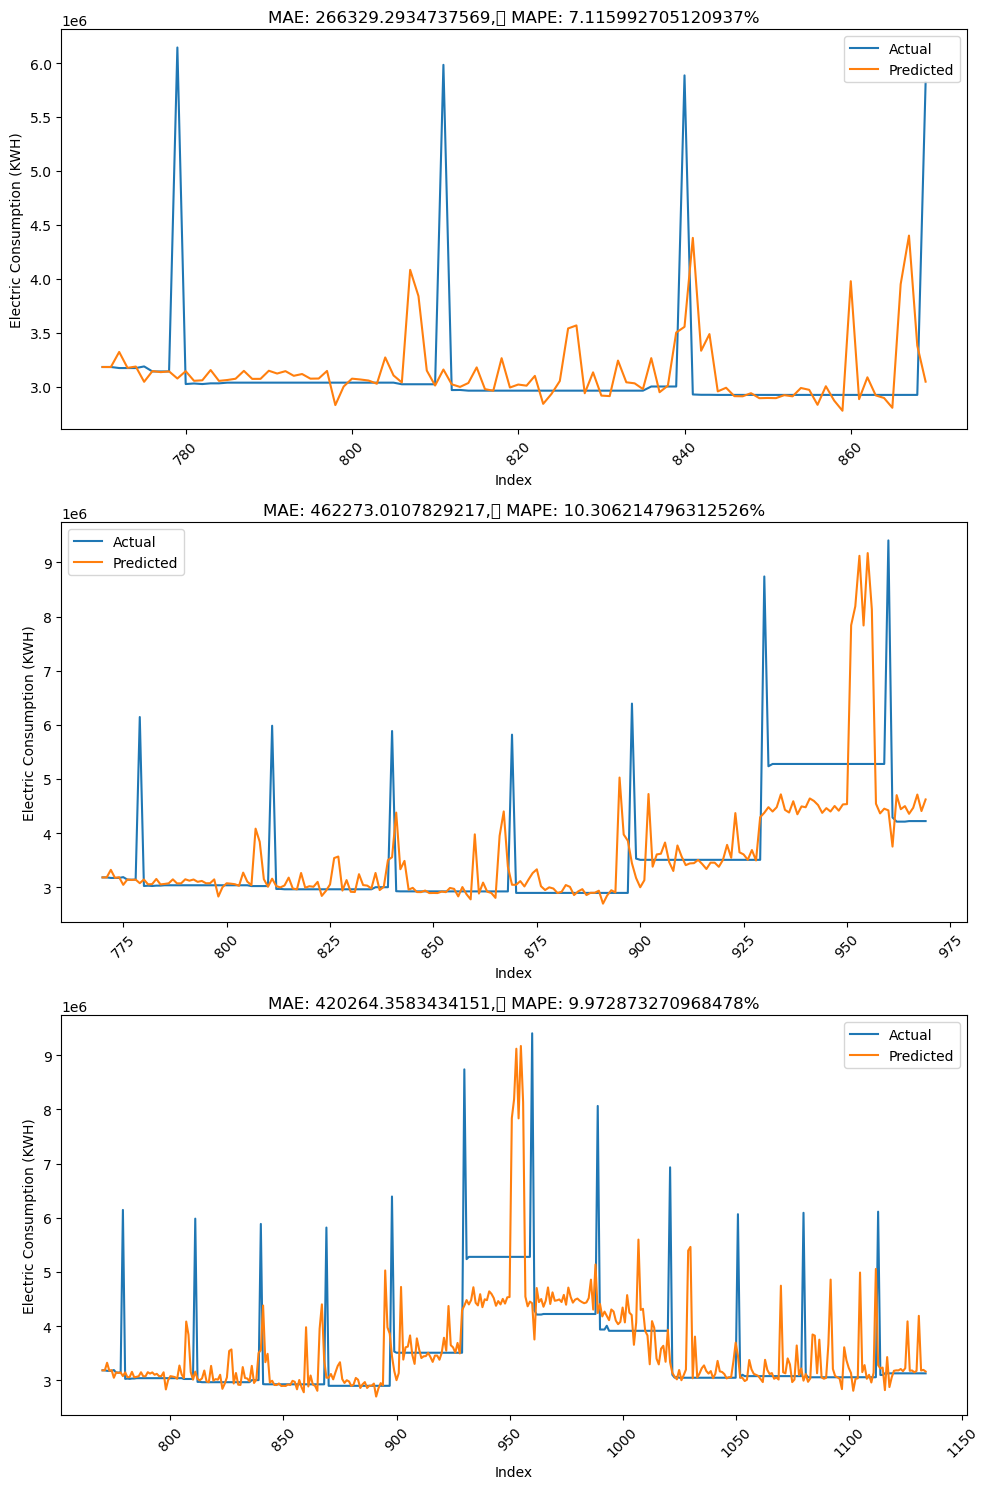

In [231]:
# from xgboost import XGBRegressor

periods = [100, 200, 365]
fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # Adjust figure size as needed

for i, period in enumerate(periods):
    model = XGBRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test[:period], predictions[:period])
    mape = np.mean(np.abs((y_test[:period] - predictions[:period]) / y_test)) * 100
    print(f"Mean absolute Error: {mae}")
    print(f"Mean absolute percentage Error: {mape}%")
    
    # Plotting the actual and predicted values
    axes[i].plot(X_test['index'][:period], y_test[:period], label='Actual')
    axes[i].plot(X_test['index'][:period], predictions[:period], label='Predicted')

    # Set titles and labels
    axes[i].set_title(f"MAE: {mae},\t MAPE: {mape}%")
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Electric Consumption (KWH)')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axes[i].legend()

mae3 = mae
mape3 = mape
    
plt.tight_layout()  # Adjust the layout
plt.show()

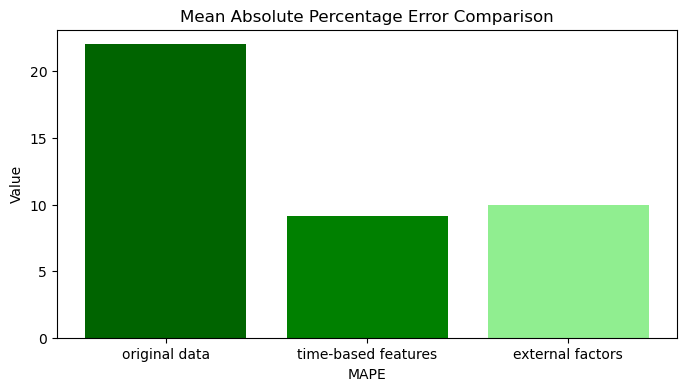

In [232]:
# plot()
plt.figure(figsize=(8, 4))  # Optional: Adjust the size of the plot
plt.bar(['original data','time-based features','external factors'], [mape1, mape2, mape3], color=['darkgreen', 'green', 'lightgreen'])
plt.title('Mean Absolute Percentage Error Comparison')
plt.xlabel('MAPE')
plt.ylabel('Value')
plt.show()

## Conclusion

### The model performs well with the lag feature for consumption. But, The performance is not upto the mark.
### If we added time-based features/external factor(Temperature), then we are able to see better model performance
### When compared to the model performance of FBProphet, Though the performance is almost the same - XGBoost regressor is much better in understanding and following the pattern of energy consumption for this particular dataset.
